# File for the Implementation of Indonesian Shape Files and Statistical Mapping

## Import Geopandas and Matplotlib 

In [1]:
import geopandas as gpd
from geopandas import *
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import openpyxl

In [2]:
#Path to Shape Files
Master_path = ('/Users/idiosyncrasy58/Dropbox/Documents/College/'+
               'Universitat Autonoma de Barcelona/IDEA - Economics/'+
               'Programming/Coursera Courses/Python/Python for Everybody/'+
               'Course 5 - Capstone/Capstone Project/Visualizations/'+
               'Creation of Shape Files/' )

path_Prov = 'Raw Shape Files/Province/map.shp'
path_Kab = 'Raw Shape Files/District/idn_adm2_simplified.shp'

#Path to SQL DB to extract GOOGLE central points
path_DB = ('/Users/idiosyncrasy58/Dropbox/Documents/College/'+
           'Universitat Autonoma de Barcelona/IDEA - Economics/'+
           'Programming/Coursera Courses/Python/Python for Everybody/'+
           'Course 5 - Capstone/Capstone Project/Final_Databases/Database/'+
           'indonesian_locations_with_geocodes.sqlite')

## Read in the Shapefiles into a Geopandas Dataframe

In [3]:
Ind_Prov = ( GeoDataFrame.from_file(Master_path+path_Prov) 
             .drop(['KODE_PROV','KODE'], axis=1, inplace=False)
             .rename(columns={'PROPINSI_':'Province'})
             .sort_index() )

In [4]:
Ind_Prov.head()

,Province,geometry
0,Bali,(POLYGON ((115.2351427588149 -8.81026996028771...
1,Banten,(POLYGON ((106.3269983435739 -5.93086266346774...
2,DI. Yogyakarta,POLYGON ((110.4943216872062 -7.767738026912674...
3,DKI Jakarta,"POLYGON ((106.6852591491924 -6.10193044540689,..."
4,Jambi,(POLYGON ((104.2475432565595 -1.03299575925923...


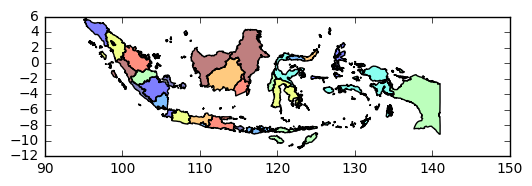

In [5]:
Ind_Prov.plot()
plt.show()

In [5]:
Ind_Kab = ( GeoDataFrame.from_file(Master_path+path_Kab)
            .rename(columns={'name':'Kabupaten'})
            .drop("id", axis=1, inplace=False) )

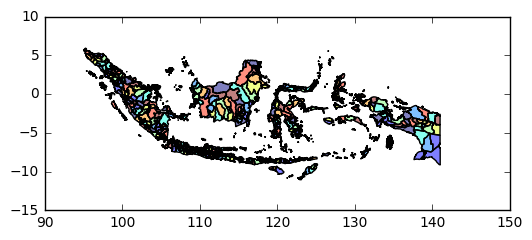

In [8]:
Ind_Kab.plot()
plt.show()

## Query the SQL database and import into Pandas the GOOGLE Maps data on region location

In [6]:
#Create the Connection
conn=sqlite3.connect(path_DB)

In [7]:
Query = 'select name,lat,lon'

In [8]:
#Query the DB and grab the BPS ids, names, and geocodes
Prov_Central_Points = pd.read_sql(Query+',id from Province',conn)
Kab_Central_Points = pd.read_sql(Query+',prov_id,id from Kabupaten',conn)
conn.close()

In [9]:
#Decode the bytes string to utf 
Prov_Central_Points['name'] = Prov_Central_Points['name'].str.decode("utf-8")
Kab_Central_Points['name'] = Kab_Central_Points['name'].str.decode("utf-8")

# Prov_Central_Points.set_index('name', inplace=True)
# Kab_Central_Points.set_index('name', inplace=True)

In [10]:
print(len(Prov_Central_Points))
print(len(Kab_Central_Points))

33
502


Use Point to convert geocodes into (x,y) = (lon,lat) coordinates

In [11]:
Prov_Central_Points["geometry"] = Prov_Central_Points.apply(
                                  lambda row: Point(row["lon"], row["lat"]), axis=1)

Kab_Central_Points["geometry"] = Kab_Central_Points.apply(
                                  lambda row: Point(row["lon"], row["lat"]), axis=1)

Prov_Central_Points.drop(['lat','lon'], axis=1, inplace=True)
Kab_Central_Points.drop(['lat','lon'], axis=1, inplace=True)

Convert the above to a GeoPandas Dataframe

In [12]:
Prov_Central_Points = gpd.GeoDataFrame(Prov_Central_Points, geometry="geometry")
Kab_Central_Points = gpd.GeoDataFrame(Kab_Central_Points,  geometry="geometry")

## Set a Coordinate Reference System for the Geo dataframes

In [13]:
#Grab the CRS from Ind_Kab (this one has a CRS builtin)
#to apply the same CRS to the GOOGLE data

Ind_Kab.crs = {"init": "epsg:4326"}
Ind_Prov.crs = {"init": "epsg:4326"}
Prov_Central_Points.crs = {"init": "epsg:4326"}
Kab_Central_Points.crs = {"init": "epsg:4326"}

## Merge the Shape Files with GOOGLE data to assign Indonesian BPS codes

### Merge Shape Files to the GOOGLE Maps Data to merge in the BPS Codes

#### Provinces
Check that the shape file has the proper KODE that corresponds to the province id in the Google Data

In [14]:
Prov_merge = ( sjoin(Ind_Prov, Prov_Central_Points, how='left', op='intersects')
               .drop(['index_right','name'],axis=1, inplace=False)
               .rename(columns={'id':'Prov Code'}).sort_values("Prov Code") )

#Add BPS code 65 to Kalimantan Utara
# Prov_merge.ix[16,"Prov Code"]=65

#Recast Codes as integers
Prov_merge["Prov Code"]=Prov_merge["Prov Code"].astype(int, copy=False)    

In [15]:
Prov_merge.head()

,Province,geometry,Prov Code
10,Aceh,"(POLYGON ((95.1129443594893 5.566434697270201,...",11
32,Sumatera Utara,(POLYGON ((98.56304499441775 1.610842788660926...,12
17,Sumatera Barat,(POLYGON ((100.3340171959681 -3.28001314087794...,13
16,Riau,(POLYGON ((102.4940984916833 1.129889926323819...,14
4,Jambi,(POLYGON ((104.2475432565595 -1.03299575925923...,15


#### Kabupatens

Merge the dataframes and create a column based on the duplication of indices given the merge

In [16]:
Kab_merge = ( sjoin(Ind_Kab, Kab_Central_Points, how='left', op='intersects')
              .drop(['index_right','name'],axis=1, inplace=False)
              .reset_index()
              .rename(columns={'index':'Dup_Values','prov_id':'Prov Code','id': 'Kab Code'})
              .sort_values('Dup_Values') )

In [17]:
Kab_merge

,Dup_Values,geometry,Kabupaten,Prov Code,Kab Code
0,0,(POLYGON ((96.66622132925679 2.119761578367781...,SIMEULUE,11.0,9.0
1,1,(POLYGON ((97.39784861497246 2.037747510936422...,ACEH SINGKIL,11.0,10.0
2,2,(POLYGON ((97.59571008217858 2.808338019510247...,ACEH SELATAN,11.0,1.0
3,3,"POLYGON ((97.82578155567407 3.749791168566073,...",ACEH TENGGARA,11.0,2.0
4,4,"POLYGON ((97.9776287281811 4.556262831641119, ...",ACEH TIMUR,11.0,3.0
5,5,"POLYGON ((96.65701847031697 4.956081410369002,...",ACEH TENGAH,11.0,4.0
6,6,"POLYGON ((96.49136700940022 4.622899261429099,...",ACEH BARAT,11.0,5.0
7,7,(POLYGON ((95.20756818729537 5.280720427284805...,ACEH BESAR,11.0,6.0
8,8,"POLYGON ((96.08644121604814 5.289263559308903,...",PIDIE,11.0,7.0
9,9,"POLYGON ((96.9054956616921 5.249965151998044, ...",BIREUEN,11.0,11.0


##### Find all duplicated values

Send to excel to assess the duplicates

In [57]:
( Kab_merge[Kab_merge.duplicated("Dup_Values",keep=False)]
  .sort_values("Kabupaten")
  .ix[:,["Kabupaten","Prov Code","Kab Code"]]
  .to_excel("Duplicate_Values.xlsx", index=False) )

##### Find all missing values

Send missing values to Excel to manually find them and place their codes in (only 34 need to be written by hand)

In [58]:
( Kab_merge[Kab_merge["Prov Code"]
  .isnull()]
  .sort_values("Kabupaten")
  .ix[:,["Kabupaten","Prov Code","Kab Code"]]
  .to_excel("Missing_Values.xlsx",index=False) )

##### Ad Hoc Corrections based on Missing and Duplicated values

There are only 12 duplicated values and 9 Kabupatens with missing Province and Kab codes (+ 1 for GORONTALO update)

In [59]:
#Drop the rows that were considered duplicates from excel examination

Kab_merge.drop(Kab_merge.index[[53,80,103,492,217,252,342]], inplace=True)

In [60]:
#Replace missing values with the proper code those with missing values

Kab_merge.ix[82,"Prov Code"]=16.0
Kab_merge.ix[82,"Kab Code"]=7.0

Kab_merge.ix[447,"Prov Code"]=31.0
Kab_merge.ix[447,"Kab Code"]=1.0

Kab_merge.ix[461,"Prov Code"]=32.0
Kab_merge.ix[461,"Kab Code"]=79.0

Kab_merge.ix[487,"Prov Code"]=52.0
Kab_merge.ix[487,"Kab Code"]=72.0

Kab_merge.ix[489,"Prov Code"]=61.0
Kab_merge.ix[489,"Kab Code"]=71.0

Kab_merge.ix[118,"Prov Code"]=21.0
Kab_merge.ix[118,"Kab Code"]=4.0

Kab_merge.ix[46,"Prov Code"]=13.0
Kab_merge.ix[46,"Kab Code"]=3.0

Kab_merge.ix[108,"Prov Code"]=18.0
Kab_merge.ix[108,"Kab Code"]=12.0

#When fixing KOTA GORONTALO, also fix GORONTALO since it was not a duplicate
#but it did have the the codes of KOTA GORONTALO in it
Kab_merge.ix[509,"Prov Code"]=75.0
Kab_merge.ix[509,"Kab Code"]=71.0

Kab_merge.ix[340,"Prov Code"]=75.0
Kab_merge.ix[340,"Kab Code"]=1.0

##### Replace the NaN values for (Prov,Kab) to 0 for those polygons that have no Kabupaten assignment (these are likely island groupings)

Also, define the Province and Kabupaten codes as integers

In [24]:
Kab_merge[["Prov Code", "Kab Code"]]=Kab_merge[["Prov Code", "Kab Code"]].fillna(0)

Kab_merge[["Prov Code", "Kab Code"]]=Kab_merge[["Prov Code", "Kab Code"]].astype(int,copy=False)

##### Drop Dup_Values column

In [25]:
Kab_merge.drop("Dup_Values",axis=1, inplace=True)

## Plot the Google Approx. Kab Central Points onto the Shape Files Map as a Check

In [74]:
#Nest the shapefiles to obtain a Kabupaten map with province outlines and the google maps data all in one
base_1 = Ind_Prov.plot(color='white', linewidth=0.4)
base_2 = Ind_Kab.plot(ax=base_1, color='white', linewidth=0.1)
Kab_Central_Points.plot(ax=base_2, marker='.', color='black', markersize=0.1)
plt.axis('off')

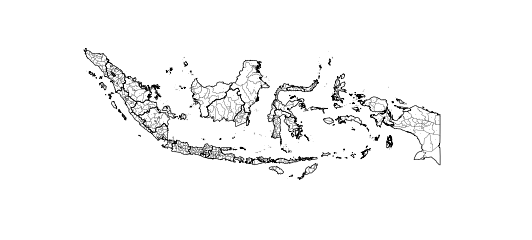

In [42]:
plt.savefig(Master_path+'Kabupaten_Province_GoogleMap_Locations.png', 
            dpi=1000, frameon=False, bbox_inches='tight', pad_inches=0.1, facecolor='#F2F2F2')
plt.show()

## Save the Two Merged Shape Files

In [26]:
Kab_merge.to_file(filename=Master_path+"/Kab_merge",driver='ESRI Shapefile')
Prov_merge.to_file(filename=Master_path+"/Prov_merge",driver='ESRI Shapefile')